In [48]:
import string
import itertools
import os
import subprocess
import random
import string
import re
import hashlib
import json
import logging

logging.basicConfig(filename="log",level=logging.INFO,filemode='w')
log = logging.getLogger("l")

patternfile = "data/pattern.txt"
os.makedirs(os.path.dirname(patternfile), exist_ok=True)

class CustomRuntimeError(Exception):
    """Something failed in runtime"""
    def __init__(self,filename,message):
        self.filename = filename
        self.message = message
        

def randomString(stringLength=256, subject=True,num = 2):
    """Generate a random string of fixed length """
    letters = string.ascii_lowercase
    if subject:
        chunk = 1024*1024*128 # 128MB
        if os.path.exists("./data/subject.txt"):
          os.remove("./data/subject.txt")
        with open("./data/subject.txt","a+") as s:
            for j in range(0,int(((stringLength+chunk-1)/chunk))):
                    rightBound = (j+1)*chunk if (j+1) * chunk < stringLength else stringLength
                    randomStr = ''.join(random.choice(letters[:num]) for i in range(j*chunk,rightBound))
                    s.write(randomStr)
        return
    else:
        randomStr =  ''.join(random.choice(letters[:num]) for i in range(stringLength))
#         with open("./data/pattern.txt","w") as s:
#             s.write(randomStr)
        return randomStr

#pats= [randomString(12,subject=False) + '\n' for j in range(20)]

# p = ['bbabbaaaaaba\n','bbbaabaabaab\n','abababaabaab\n','aabbbaababba\n','aabbbaababab\n','aabbbabaabba\n','bbabbbabbaba\n','aababaabaaab\n','ababbaaaaaaa\n','bababaaabaab\n','abaabaaaaaba\n','babaabaabaab\n','bbaaabaabaab\n','aabbbabbaaba\n','aababaababaa\n','aabbbabbabba\n','baabbbabbaba\n','aabbbaababab\n','ababbaabaaaa\n','bababaaabaab\n']

p = ['bbabbaaaaaba\n' for i in range(15)]

print(len(set(p)))
# path to nvprof
nvprof = "/usr/local/cuda-10.2/bin/nvprof"

programs = ['kspec','nspec','nspecc','nglobalc','nglobal','nconstc','nconst','kglobal','kconst']

def match(pattern,filename,size = 0, offset = 0, verbose=1):
    
#     commands to collect profile data: 2> to redirect nvprof stderr output
# Options:
# ("pattern","path to file with patterns to look for") if multiple patterns the delimiter should be \x00, 
#     single pattern size should be < cuda block_size(1024 by default) and length of patterns in total should be < 128*64 and
#     the number of patterns should be < 64
# ("filename","path to file with subject string)
# ("size", "size of data to be fectched from @filename in bytes")
# ("offset", "offset of data to be fetched from @filename read in bytes")
# ("algorithm","algorithm name to run pattern matching with")
# Available names for type=0:
#     mcleanpe --- for match_spec.out --- partially evaluated version
#     mnaive --- for match.out --- naive cuda implementation with patterns residing in global memory
#     mnaivec --- for match.out --- naive cuda implementation with patterbs residing in constant memory
#     mnaivesh --- for match.out --- naive cuda implementation with patterns residing in shared memory

# ("type","type of algorithm parallelization: 0 stands for nochunk-based(thread per subject string byte) and 1 for chunk-based(data-parallel)")
# ("v,verbose","print matching result or not to stdout: 0 stands for 'No' 1 for 'Yes'");
    commands = [

#     f"{nvprof} --normalized-time-unit ms ./match_spec.out --pattern={pattern} --filename={filename} --algorithm=mcleanpe --type=1 --size={size} --offset={offset} --verbose={verbose} 2> mclean_pe_nochunk.txt",
#     f"{nvprof} --normalized-time-unit ms ./match.out --pattern={pattern} --filename={filename} --algorithm=mnaivec --type=1 --size={size} --offset={offset} --verbose={verbose} 2> cuda_mnaivec_nochunk.txt",
#     f"{nvprof} --normalized-time-unit ms ./match.out --pattern={pattern} --filename={filename} --algorithm=mnaive --type=1 --size={size} --offset={offset} --verbose={verbose} 2> cuda_mnaive_nochunk.txt",
# #     f"{nvprof} --normalized-time-unit ms ./match.out --pattern={pattern} --filename={filename} --algorithm=mnaivesh --type=1 --size={size} --offset={offset} --verbose={verbose} 2> cuda_mnaivesh_nochunk.txt",
# #     f"{nvprof} --normalized-time-unit ms ./match.out --pattern={pattern} --filename={filename} --algorithm=mnaivetex --type=1 --size={size} --offset={offset} --verbose={verbose} 2> cuda_mnaivetex_nochunk.txt",
#     f"{nvprof} --normalized-time-unit ms ./match.out --pattern={pattern} --filename={filename} --algorithm=mnavecs --type=1 --size={size} --offset={offset} --verbose={verbose} 2> cuda_mnaivecs_nochunk.txt",
        f"./MatchSingleBench --patternfile={patternfile} --datafile={filename} --size={size} --benchmark={b} >{b}-prof.txt" for b in programs        
    ]
    
    for command in commands:
        log.info(f"command: {command}")
        if(os.system(command) == 0):
            continue
        raise CustomRuntimeError(command,"")


# rePatt = re.compile('[\d]+\.?[\d]*')
reNumber = re.compile('[-+]?[0-9]*\.?[0-9]+[eE]?[-+]?[0-9]+')

        
class Runner():
    
    def __init__(self,sizes,patterns,filename,salt,patSizes = []):
        self.filename = filename
        self.sizes = sizes
        self.patSizes = patSizes
        self.patterns = patterns
        self.output_file = f"check_time_{salt}_{self.filename.split('/')[-1]}"
        self.match_count = []
        self.compile_times = [[] for i in sizes]
        
    def time(self,compile_times):
#     rePatt = [re.compile('PFAC_kernel_timeDriven<int=256, int=128, int=0, int=1>'), re.compile('lambda_\w*')]
        rePatt = re.compile('runtime')
        result = []
        compile_time = []
        for file in programs:
            success = False
            with open(f'{file}-prof.txt',"rb") as mN:
                for line in mN.readlines():
                    try:
                        ld = line.decode('utf-8')
                    except UnicodeDecodeError:
                        continue
                    if (rePatt.findall(ld) != []):
                        result.append(ld)
                        success = True
                    if (re.compile("Compile time|Cuda compile time").findall(ld) != []):
                        compile_time.append(int(reNumber.findall(ld)[0]))
                if(not success):
                    with open(file) as f:
                        raise CustomRuntimeError(file,f.readlines())
        compile_times_scalar = 0
        for c in compile_time:
            compile_times_scalar += c
        compile_times.append(compile_times_scalar)
        return(result)

    def checkTimeStatic(self,size,filename,patterns,i):
        res = []
        for p in patterns:
            with open(patternfile, 'w') as fb:
                     log.info(f"pattern {p}")
                     fb.write(p)
            match(patternfile,filename,size*1024*1024)
            clocks = []
            for line in self.time(self.compile_times[i]):
                log.info(f"line: {reNumber.findall(line)}")
                clocks.append(reNumber.findall(line))
            entry = [x[0] for x in clocks] # x[0] is time
            res.append(entry)
        return res
    
    def run(self):
        #2GB
#         randomString(1024*1024*1024*2,16)
        #dry run to compile PE
        run_times = []
        res = {}
        i = 0
        for s in self.sizes:
            try:
                if self.patSizes == []:
                    run_times.append(self.checkTimeStatic(s,self.filename,self.patterns,i))
                else:
#                     print(i)
#                     print(self.patSizes[i])
                    run_times.append(self.checkTimeStatic(s,self.filename,[(b'\n'.join(sorted(self.patterns)[:self.patSizes[i]]) + b'\n')]))
            except CustomRuntimeError as crt:
                print(f"Error occured while trying to run tests\n {crt.message} in {crt.filename}")
                return ""
            i = i + 1
#         with open(f'check_time_{output_file}','w+') as cts:
#             cts.write(str(res))
        with open(self.output_file,'w') as cts:
            res["run_times"] = run_times
            res["compile_times"] = self.compile_times
            cts.write(json.dumps(res))
        return res

# generates set of random patterns sets if pats = [] with chars of given alphabet size: 
# @length is the length of each pattern, @size --- number of patterns in each set, @num --- number of sets
def generateMultiPattern(length=0,size=0,num=0,pats = [],alphabet = 2):
    if(len(pats) == 0):
        return [b'\x00'.join([randomString(length,False,alphabet).encode('ascii') for x in range (0,size)]) for i in range(num)] #set of 4 multipatterns sets =)
    else:
        if(size < len(pats)):
            return [b'\x00'.join(random.sample(pats,k=size)) for x in range(0,num)]
        else:
            return [b'\x00'.join(random.choices(pats,k=size)) for x in range(0,num)]
    
def generatePatterns(length,num,alphabet=2):
    return list(map(lambda l:l.encode('ascii'),[randomString(length,False,alphabet) for x in range(0,num)]))


#take @size bytes with @offset offset from certain @device, e.g. sda1 (sda1 shoud have appropriate chmod for this)


# memory_dump("/dev/sda1",10*1024*1024*1024,3*1024*1024*1024)


#collect timings
# runner = Runner(sizes_[:15],patterns=generateMultiPattern(length=0,size=16,num=5,pats=realWorldPatterns),filename='/dev/sda1',offset=0,verbose=0)

# @sda1dump is file dumped with @memory_dump("/dev/sda1",...)
# pats = [b'\x00'.join(sorted(realWorldPatterns)) for i in range(0,10)]
sizes = [i for i in range(10,201,40)]

pat_data = "/home/alekseey_tyurin_gmail_com/specialization/spec/aho-corasick/benchmarking/data/data_from_patterns"
pdf_data = "/home/alekseey_tyurin_gmail_com/specialization/spec/aho-corasick/benchmarking/data/pdfsdump"
subj_data = "/home/alekseey_tyurin_gmail_com/specialization/spec/aho-corasick/benchmarking/data/subject.txt"


runner = Runner(sizes = sizes,patterns=p,filename=subj_data,salt="same_pat")
                               
runner.run()

# runner = Runner(sizes_[:16],patterns=generateMultiPattern(length=0,size=16,num=7,pats=realWorldPatterns),filename='sda1dump',offset=0,verbose=0)
# runner = Runner(sizes,pats,filename='/home/bolkonskiy322_gmail_com/specialization/spec/aho-corasick/benchmarking/data/pdfsdump',offset=0,verbose=0)
# run benchmarks
#runner.run()
# print(sizes_[:13])



    

1


{'run_times': [[['1.39427',
    '0.55808',
    '1.85491',
    '2.0359',
    '0.734208',
    '1.87622',
    '0.755712',
    '2.92947',
    '2.69677'],
   ['1.39126',
    '0.557632',
    '1.8513',
    '2.03718',
    '0.734144',
    '1.87418',
    '0.756352',
    '2.85418',
    '2.80928'],
   ['1.39427',
    '0.558112',
    '1.85181',
    '2.03632',
    '0.733824',
    '1.87542',
    '0.756224',
    '2.79101',
    '2.73024'],
   ['1.40243',
    '0.557888',
    '1.85248',
    '2.03699',
    '0.734432',
    '1.87878',
    '0.756352',
    '2.90637',
    '2.87117'],
   ['1.40016',
    '0.5576',
    '1.8544',
    '2.03866',
    '0.734208',
    '1.8736',
    '0.75616',
    '2.79075',
    '2.70371'],
   ['1.39667',
    '0.55776',
    '1.85283',
    '2.04035',
    '0.734048',
    '1.87725',
    '0.756288',
    '2.93075',
    '2.74045'],
   ['1.39405',
    '0.558048',
    '1.8527',
    '2.04077',
    '0.733856',
    '1.87533',
    '0.756448',
    '2.76461',
    '2.82816'],
   ['1.3969',
    '0.558

<IPython.core.display.Javascript object>


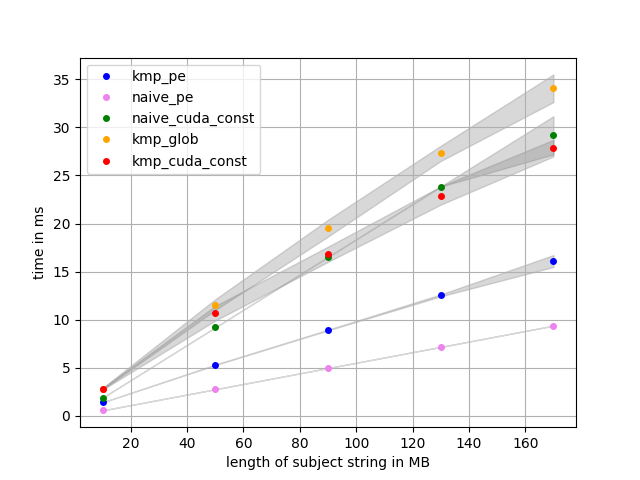

In [53]:
from functools import reduce
from IPython.display import Image
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import math
import matplotlib.ticker as plticker
import json
import numpy as np



def red(test_list):
    res = [0 for i in range(0,len(test_list[0]))];#12
    for i in test_list: #for each pair
        for j in range(0,len(res)):#7
            res[j]+=int(i[j])
    return list(map(lambda x : x / len(test_list) ,res))

def deviation_float(test_list,avg):
    dev = [[0 for i in range(len(test_list[0][0]))] for j in range(len(test_list))] #for each size
    for i in range(len(test_list)): #for each size
        for j in range(len(test_list[i])): #for each run
            for e in range(len(test_list[i][j])): #for each benchmark in a run
                val = float(test_list[i][j][e])
# #                 if(val > 1 and val < 2):
# #                     val = val * 1000
                dev[i][e] = dev[i][e] + (((val - avg[i][e])**2) / (len(test_list[i])-1)) #std dev
#     return dev
    res = [[] for i in range(len(avg))] # number of sizes
    for i in range(len(avg)): #for each bench
        for e in (dev[i]): #for each size
             res[i].append(math.sqrt(e))
    return res


def build_set_float(test_list):
    size = len(test_list)
    def red_(l):
        res = [0 for i in range(0,len(l[0]))];#12
        for i in l: #for each pair
            for j in range(0,len(res)):#7
                value = float(i[j])
                res[j] += value
        return list(map(lambda x : x / len(l) ,res))
    
    res = [[] for i in range(0,size)]
    for i,j in enumerate(test_list): #for each text size
        data_ = red_(j) #average for specific run
        res[i] = data_
    return res

# read captured data
data = []
# file = 'check_time_subject.txt'
file = runner.output_file
with open(file,'rb') as dump:
    source = dump.read()
    data = json.loads(source)
    
# print(len(data["run_times"][0]))    
empirical_avg = (build_set_float(data["run_times"]))

# print(deviation_float(data["run_times"],empirical_avg))

dev = np.array(deviation_float(data["run_times"],empirical_avg)).transpose()
avg = np.array(empirical_avg).transpose()


mns_devplus = [[avg[j][i]+dev[j][i] * 1 for i in range(len(avg[j]))] for j in range(len(avg))] #6
mns_devminus = [[avg[j][i]-dev[j][i] * 1 for i in range(len(avg[j]))] for j in range(len(avg))]

# # args = [100, 300, 500, 700, 900, 1100, 1300, 1500, 1700, 1900, 2100, 2300, 2500, 2700, 2900, 3100, 3300, 3500, 3700, 3900, 4100, 4300, 4500, 4700, 4900, 5100, 5300, 5500, 5700, 5900, 6100, 6300, 6500, 6700, 6900, 7100, 7300]

# args = [10,20,30,40,50,60]
args = sizes
# print(len(sizes))
# args = [i for i in range(50,1001,50)]
# print(len(args))

# yticks = [0,100,200,300,400,500,600,700,800,900,1000,1100,1200,1300,1400,1500]
# yticks_ = [i for i in range(0,501,50)]

points = len(data["run_times"])

# plt.yticks(yticks_)
# plt.xticks((args[2::5]) + [7300])
# plt.xticks([50,100,200,300,400,500,600,700,800,900,1000])
plt.grid()
programs_filter = ['kspec','kconst','nconstc','nspec']
programs_titles = ['kmp_pe','kmp_cuda_const','naive_cuda_const','naive_pe']


colors = ['blue','violet','green','red','yellow','green','cyan','orange','red']

for i,j in enumerate(programs):
    try: 
        index = programs_filter.index(j)
    except ValueError:
        continue
    plt.fill_between(args,mns_devplus[i],mns_devminus[i],interpolate=False,color='gray', alpha=0.3)
    plt.plot(args,avg[i],'o',label=programs_titles[index],color=colors[i], markersize=4)
#     print(j)

# plt.fill_between(args[:points],mns_devplus[0],mns_devminus[0],interpolate=False,color='gray', alpha=0.3)
# plt.fill_between(args[:points],mns_devplus[1],mns_devminus[1],interpolate=False,color='gray', alpha=0.3)
# plt.fill_between(args[:points],mns_devplus[2],mns_devminus[2],interpolate=False,color='gray', alpha=0.3)
# plt.fill_between(args[:points],mns_devplus[3],mns_devminus[3],interpolate=False,color='gray', alpha=0.3)
# plt.fill_between(args[:points],mns_devplus[4],mns_devminus[4],interpolate=False,color='gray', alpha=0.3)

# plt.plot(args[:points],empirical_avg[0],'o',label='partially_evaluated',color='violet',markersize=4)
# plt.plot(args[:points],empirical_avg[1],'^',label='cuda_global',color='red',markersize=5)
# plt.plot(args[:points],empirical_avg[2],'x',label='cuda_constant',color='blue',markersize=7)
# plt.plot(args[:points],empirical_avg[3],'s',label='cuda_const_sizes',color='aqua',markersize=7)
# # plt.plot(args[:points],empirical_avg[3],'s',label='cuda_shared',color='green',markersize=5)
# # plt.plot(args[:points],empirical_avg[4],'p',label='cuda_tex',color='orange',markersize=5)


plt.ylabel('time in ms')
plt.xlabel('length of subject string in MB')

plt.legend()
plt.show()

# # uncomment to save figure
# plt.savefig('data/KMP_TEST.pdf')